In [1]:
import torch
from torch import nn

In [14]:
torch.stack([torch.arange(3),torch.arange(3)],0)

tensor([[0, 1, 2],
        [0, 1, 2]])

torch.Size([996, 4]) torch.Size([996, 1])


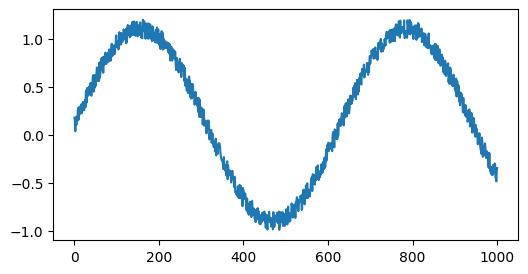

In [34]:
from d2l_common import DataModule
import matplotlib.pyplot as plt


class Data(DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
        self.tau = tau
        self.num_train = num_train
        self.batch_size = batch_size
        self.T = T
        self.time = torch.arange(1, T+1, dtype=torch.float32)
        self.x = torch.sin(0.01*self.time)+torch.rand(T)*0.2

    def get_dataloader(self, train):
        features = [self.x[i:self.T-self.tau+i] for i in range(self.tau)]
        self.features = torch.stack(features, 1)
        self.labels = self.x[self.tau:].reshape(-1, 1)
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.features, self.labels], train, i)


data = Data()
data.get_dataloader(True)
print(data.features.shape, data.labels.shape)

plt.figure(figsize=(6, 3))
plt.xlim = [1, 1000]
plt.plot(data.time, data.x)
plt.xlabel = 'time'
plt.ylabel = 'x'
plt.show()

In [20]:
from d2l_common import LinearRegression, Trainer

model = LinearRegression(lr=0.01)
trainer = Trainer(max_epochs=5)
trainer.fit(model, data)

/Users/tangyun/opt/miniconda3/envs/rl/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


complete 0 epoch train_loss=0.055069662630558014 validate_loss=0.05225608870387077
complete 1 epoch train_loss=0.021670391783118248 validate_loss=0.015407011844217777
complete 2 epoch train_loss=0.007937401533126831 validate_loss=0.0072408090345561504
complete 3 epoch train_loss=0.0030906875617802143 validate_loss=0.005038758739829063
complete 4 epoch train_loss=0.004401868209242821 validate_loss=0.004198582377284765


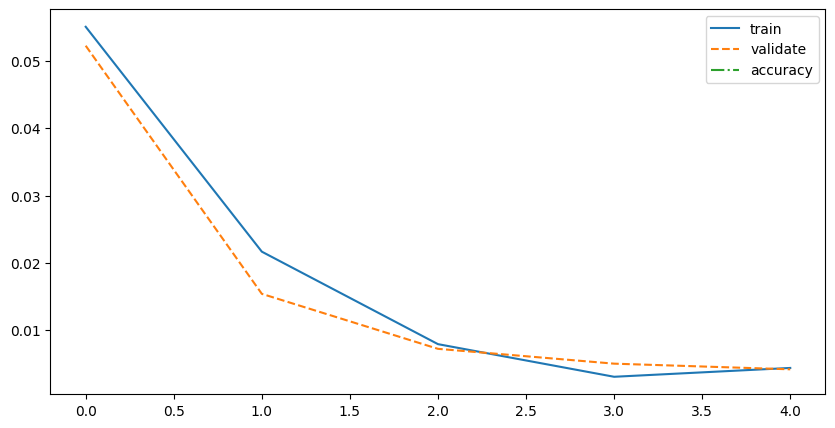

In [21]:
trainer.plot()

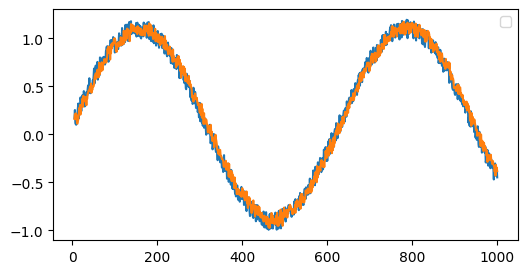

In [29]:
onestep_preds = model(data.features).detach().numpy()
plt.figure(2, figsize=(6, 3))
plt.xlabel = 'time'
plt.ylabel = 'x'
plt.legend(['labels', '1-step preds'])
plt.plot(data.time[data.tau:], data.labels, label='labels')
plt.plot(data.time[data.tau:], onestep_preds, label='1-step')
plt.show()

In [32]:
onestep_preds.shape

(996, 1)

torch.Size([1000])


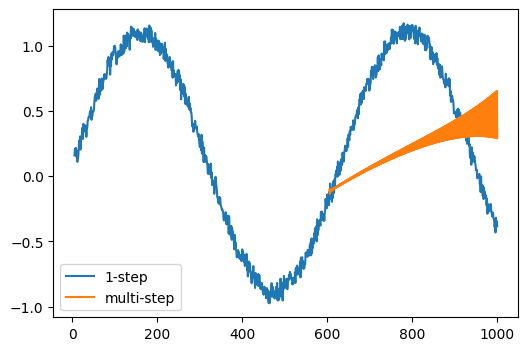

In [55]:
multistep_preds = torch.zeros(data.T)
# print(multistep_preds)
multistep_preds[:] = data.x

for i in range(data.num_train+data.tau, data.T):
    # from 604 to 1000
    multistep_preds[i] = model(multistep_preds[i-data.tau:i].reshape(1, -1))

print(multistep_preds.shape)
multistep_preds = multistep_preds.detach().numpy()

x = plt.figure(figsize=(6, 4))
plt.plot(data.time[data.tau:], onestep_preds)
plt.plot(data.time[data.num_train+data.tau:],
         multistep_preds[data.num_train+data.tau:])
# plt.xlabel = 'time'
# plt.ylabel = 'x'
plt.legend(['1-step','multi-step'])
plt.show()

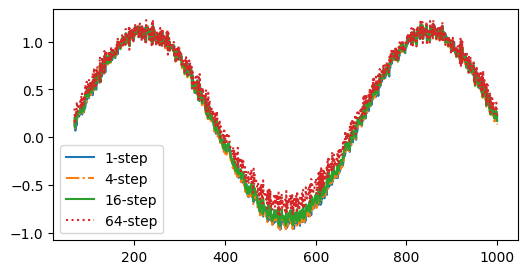

In [66]:
def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i:i+data.T-data.tau-k+1])
    for j in range(k):
        preds = model(torch.stack(features[j:j+data.tau], 1))
        features.append(preds.reshape(-1))

    return features[data.tau:]


steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
plt.figure(figsize=(6, 3))
plt.plot(data.time[data.tau+steps[-1]-1:],preds[0].detach().numpy(),linestyle='solid')
plt.plot(data.time[data.tau+steps[-1]-1:],preds[3].detach().numpy(),linestyle='-.')
plt.plot(data.time[data.tau+steps[-1]-1:],preds[15].detach().numpy(),linestyle='-')
plt.plot(data.time[data.tau+steps[-1]-1:],preds[63].detach().numpy(),linestyle=':')
plt.legend(['1-step','4-step','16-step','64-step'])
plt.show()